In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from collections import defaultdict
import math
import json
import xarray as xr

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct, RBF 
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import KFold

from codes.embedding import Embedding
from codes.environment import Rewards_env
from codes.ucb import GPUCB, Random
from codes.evaluations import evaluate, plot_eva
from codes.regression import *
from codes.kernels_for_GPK import *

import pickle
import xarray

from ipywidgets import IntProgress
from IPython.display import display
import warnings
%matplotlib inline

In [2]:
# Parameters for pipeline 
# num_split = 5
# num_repeat = 10
# s_list = [0,1]
# alpha_list= [0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1] + list(range(1,11))
# l_list = [3, 6]

with open('repeated_kfold_wd_shift_round01_without_kernelNorm.pickle', 'rb') as handle:
    result_pkl = pickle.load(handle)

**Update**: run repeated kfold for round 0 + round 1 results ['../../data/Results_Microplate_partialFalse_normTrue_roundRep_formatSeq_logTrue.csv'] without kernel normalisation, recorded in [repeated_kfold_wd_shift_round01_without_kernelNorm.pickle].   
Parameters: 
- num_split = 5
- num_repeat = 5
- s_list = [0,1]
- alpha_list= [1e-5, 1e-1, 0.5, 1, 2, 5] 
- l_list =[3,4,5,6]
- sigma_0_list = [1]

use xarray to store results
dimensions:

- train_test: results for train(0) or test(1) 
- eva_on: evaluate on sample labels(0) or average(1)
- eva_metric: mean square error(0) or r2 score(1)
- alpha (parameter of GPR, which adds to the diagonal of kernel matrix)
- l (length of kmer)
- s (shift length)
- repeat (nth repeat)
- fold (k-fold)

## Train performance

Report performance in terms the average score of repeats and folds.  
Visualisation can only do for two dimensions, so separate s = 0 and s = 1.

First row: eva_on = samples; Second row: eva_on = seqs  
First col: eva_metric = MSE (the higer the better); Second col: eva_metric = R2 (the lower the better)

x, y axis:  
alpha_list= [0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1] + list(range(1,11))  
l_list = [3, 6]

In [3]:
ave_train_result = result_pkl[0].mean(axis = -1).mean(axis = -1)

s = 0, i.e. wd kernel.

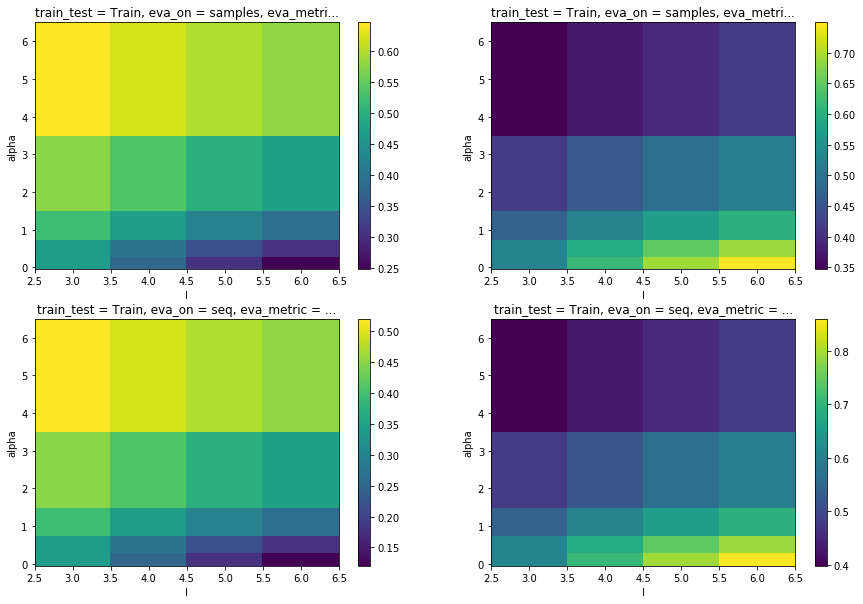

In [4]:
num_rows = 2
num_cols = 2

fig,a = plt.subplots(num_rows, num_cols, figsize = (15,10))

for i in range(num_rows):
    for j in range(num_cols):
        ave_train_result[i][j].loc[dict(s = 0)].plot(ax=a[i][j])

s = 1, i.e. wd kernel with 1 shift

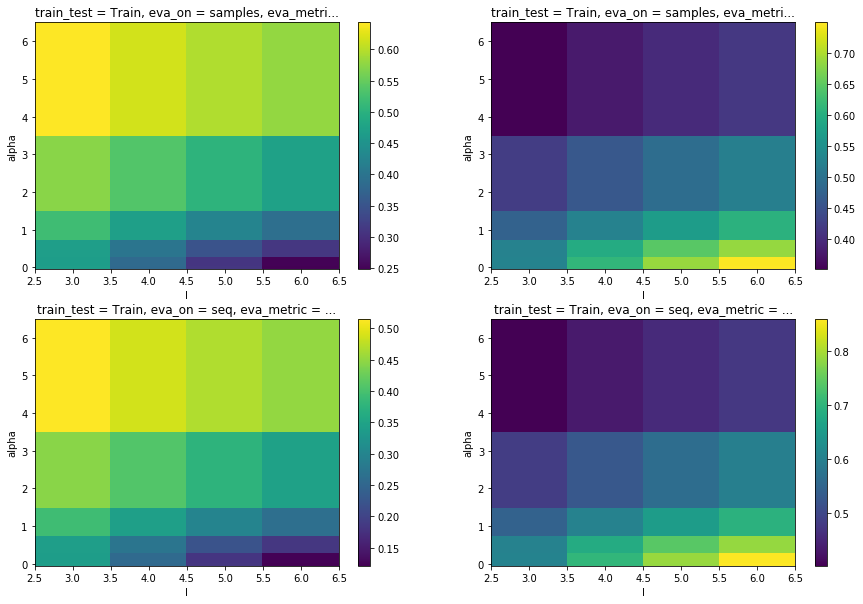

In [5]:
num_rows = 2
num_cols = 2

fig,a = plt.subplots(num_rows, num_cols, figsize = (15,10))

for i in range(num_rows):
    for j in range(num_cols):
        ave_train_result[i][j].loc[dict(s = 1)].plot(ax=a[i][j])

Summary: for training
- s = 0 or 1 almost does not influence the performance.
- for both eva metric, the LOWER the alpha, and when l = 6, the performance is better.
- for both eva on samples or averages, the trend is the same, while the value is different (seq has a smaller MSE, bigger R2). So the choice of best parameter does not be influenced by the eva_on.

## Test performance

Report performance in terms the average score of repeats and folds.  
Visualisation can only do for two dimensions, so separate s = 0 and s = 1.

First row: eva_on = samples; Second row: eva_on = seqs  
First col: eva_metric = MSE (the higer the better); Second col: eva_metric = R2 (the lower the better)

x, y axis:  
alpha_list= [0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1] + list(range(1,11))  
l_list = [3, 6]

In [6]:
ave_test_result = result_pkl[1].mean(axis = -1).mean(axis = -1)

s = 0, i.e. wd kernel.

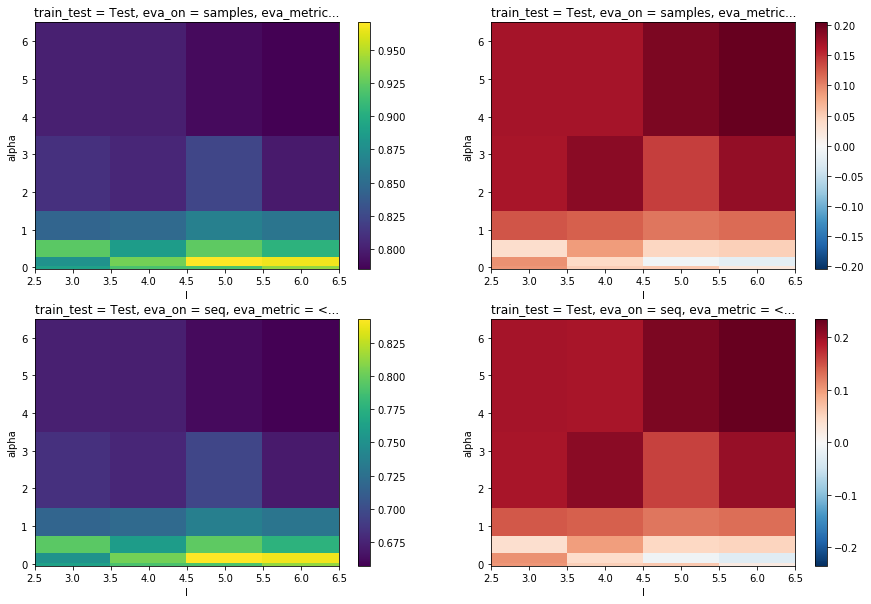

In [7]:
num_rows = 2
num_cols = 2

fig,a = plt.subplots(num_rows, num_cols, figsize = (15,10))

for i in range(num_rows):
    for j in range(num_cols):
        ave_test_result[i][j].loc[dict(s = 0)].plot(ax=a[i][j])

s = 1, i.e. wd kernel with 1 shift

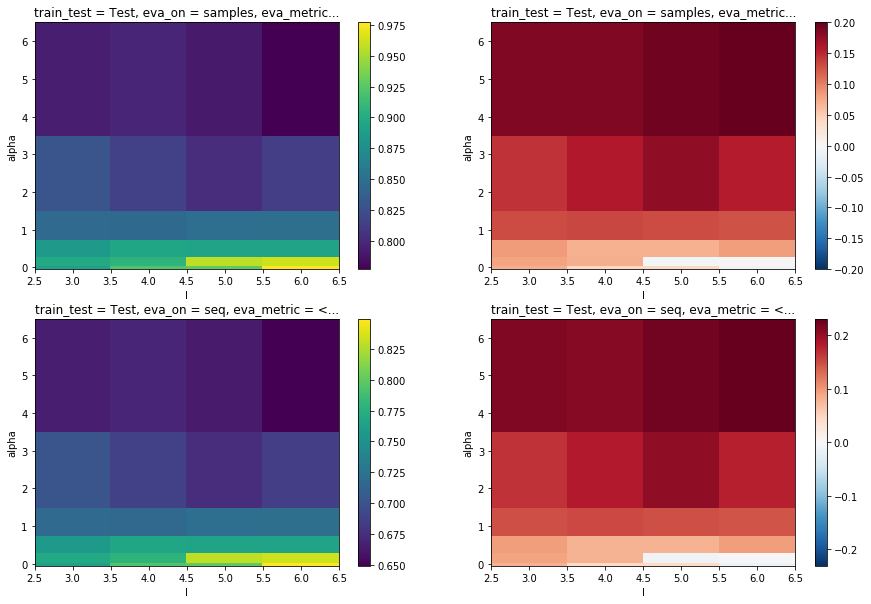

In [8]:
num_rows = 2
num_cols = 2

fig,a = plt.subplots(num_rows, num_cols, figsize = (15,10))

for i in range(num_rows):
    for j in range(num_cols):
        ave_test_result[i][j].loc[dict(s = 1)].plot(ax=a[i][j])

Summary: for testing
- s still does not influence too much. But when l=3, s = 0 does better; l=6, s = 1 does better for smaller alphas.
- for both eva metric, the HIGHER the alpha, and when l = 6, the performance is better.
- for both eva on samples or averages, the trend is the same, while the value is different (seq has a smaller MSE, similar R2). So the choice of best parameter does not be influenced by the eva_on.

## Select parameters and show performance

based on above results, we choose

- l = 6
- alpha = 0,2,5
- s = 1

In [13]:
Path = '../../data/Results_Microplate_partialFalse_normTrue_roundRep_formatSeq_logTrue.csv'

df = pd.read_csv(Path)
df.head()

,Unnamed: 0,Name,Group,Plate,Round,RBS,RBS6,Rep1,Rep2,Rep3,...,Rep5,Rep6,Rep7,Rep8,Rep9,AVERAGE,STD,Pred Mean,Pred Std,Pred UCB
0,0,RBS_1by1_0,reference,First_Plate,0,TTTAAGAAGGAGATATACAT,AGGAGA,2.433056,2.502155,2.315237,...,2.917124,2.275329,NaN,NaN,NaN,2.575968,0.313540,NaN,NaN,NaN
1,1,RBS_1by1_1,bps_noncore,First_Plate,0,CTTAAGAAGGAGATATACAT,AGGAGA,1.556251,1.654243,1.762146,...,2.312790,1.959275,NaN,NaN,NaN,1.839138,0.268820,NaN,NaN,NaN
2,2,RBS_1by1_2,bps_noncore,First_Plate,0,GTTAAGAAGGAGATATACAT,AGGAGA,0.603551,0.748674,0.921939,...,0.503846,0.711231,NaN,NaN,NaN,0.646754,0.188587,NaN,NaN,NaN
3,3,RBS_1by1_3,bps_noncore,First_Plate,0,ATTAAGAAGGAGATATACAT,AGGAGA,1.658359,1.874275,1.534988,...,1.747116,1.232548,NaN,NaN,NaN,1.598899,0.220191,NaN,NaN,NaN
4,4,RBS_1by1_4,bps_noncore,First_Plate,0,TCTAAGAAGGAGATATACAT,AGGAGA,1.545942,2.072095,1.386300,...,1.774833,2.146898,NaN,NaN,NaN,1.812638,0.300722,NaN,NaN,NaN


X train shape:  (1276, 20)
X test shape:  (53, 20)
create kernel instance
USE non-normalised kernel!
init kernel
finish creating kernel instance
gp_reg fit
gp_reg pred
finish reg
<function mean_squared_error at 0x7fa21fcab488>
Train:  0.13711041838572993
Test:  0.5744658227764264
<function r2_score at 0x7fa21fcab6a8>
Train:  0.8456269446723641
Test:  0.24645079485921484


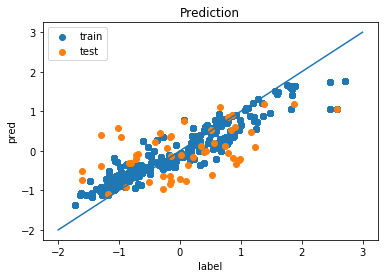

In [25]:
kernel = 'WD_Kernel_Shift'
embedding = 'label'
eva_metric = [mean_squared_error, r2_score]

gpr_train_samples = GPR_Predictor(df, kernel_name = kernel, embedding = embedding, eva_metric = eva_metric,
                   l = 6, s = 1, alpha = 0, eva_on='seqs', sigma_0=1)
gpr_train_samples.regression()
gpr_train_samples.scatter_plot()

X train shape:  (1276, 20)
X test shape:  (53, 20)
create kernel instance
USE non-normalised kernel!
init kernel
finish creating kernel instance
gp_reg fit
gp_reg pred
finish reg
<function mean_squared_error at 0x7fa21fcab488>
Train:  0.37352895193924524
Test:  0.4999324936267345
<function r2_score at 0x7fa21fcab6a8>
Train:  0.5794425672163777
Test:  0.3442190670704327


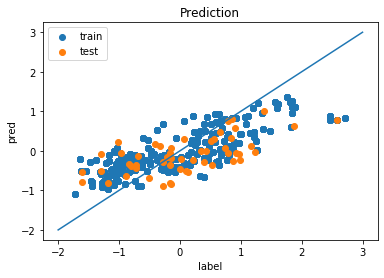

In [26]:
kernel = 'WD_Kernel_Shift'
embedding = 'label'
eva_metric = [mean_squared_error, r2_score]

gpr_train_samples = GPR_Predictor(df, kernel_name = kernel, embedding = embedding, eva_metric = eva_metric,
                   l = 6, s = 1, alpha = 2, eva_on='seqs', sigma_0=1)
gpr_train_samples.regression()
gpr_train_samples.scatter_plot()

X train shape:  (1276, 20)
X test shape:  (53, 20)
create kernel instance
USE non-normalised kernel!
init kernel
finish creating kernel instance
gp_reg fit
gp_reg pred
finish reg
<function mean_squared_error at 0x7fa21fcab488>
Train:  0.48174902063929115
Test:  0.5081366168942346
<function r2_score at 0x7fa21fcab6a8>
Train:  0.45759724831440085
Test:  0.3334573988875932


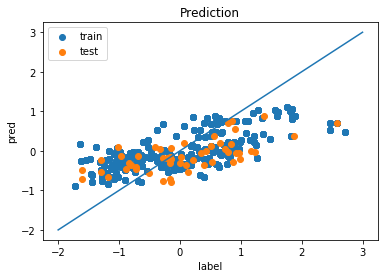

In [27]:
kernel = 'WD_Kernel_Shift'
embedding = 'label'
eva_metric = [mean_squared_error, r2_score]

gpr_train_samples = GPR_Predictor(df, kernel_name = kernel, embedding = embedding, eva_metric = eva_metric,
                   l = 6, s = 1, alpha = 5, eva_on='seqs', sigma_0=1)
gpr_train_samples.regression()
gpr_train_samples.scatter_plot()